In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

/home/rainorangelemon/Documents/tiny-diffusion


/home/rainorangelemon/micromamba/envs/robodiff/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Energy Values

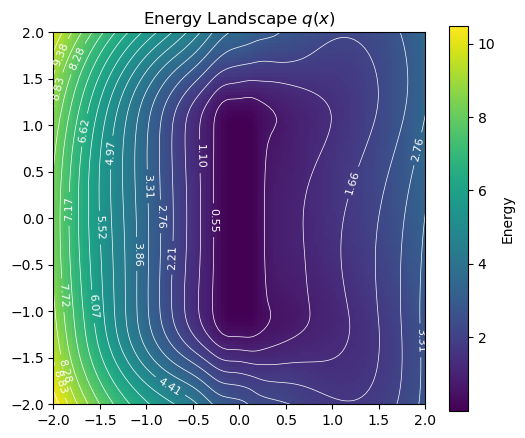

In [18]:
import torch
import ddpm
import matplotlib.pyplot as plt
import numpy as np

# draw the energy landscape
model_1 = ddpm.EnergyMLP()
model_1.load_state_dict(torch.load("exps/product_a2/ema_model.pth"))
model_to_test = model_1.cuda()

plt.clf()
plt.close('all')
plt.figure(figsize=(6, 5))
t = 0
# meshgrid the space
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
Z = model_to_test.energy(torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).cuda().float(),t+torch.zeros(10000).long().cuda()).detach().cpu().numpy().reshape(100, 100)
# Z = np.exp(-Z)
plt.imshow(Z.reshape(100, 100), extent=[-2, 2, -2, 2])
plt.colorbar(label='Energy')

# Add level sets
levels = np.linspace(Z.min(), Z.max(), 20)  # Adjust the number of levels as needed
contours = plt.contour(X, Y, Z, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contours, inline=True, fontsize=8, fmt='%.2f')
plt.title(r'Energy Landscape $q(x)$')

plt.savefig('figures/proof_of_concept/energy_landscape.png')
plt.show()

plt.clf()
plt.close('all')

# Original Data Samples

<Figure size 640x480 with 0 Axes>

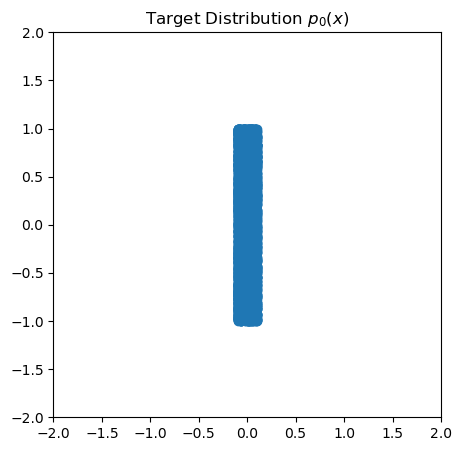

In [19]:
from datasets import generate_data_points
plt.clf()
dataset = generate_data_points(dataset='product_a2', n=10000)
plt.figure(figsize=(5, 5))
plt.scatter(dataset[:,0], dataset[:,1])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title(r'Target Distribution $p_0(x)$')
plt.savefig('figures/proof_of_concept/target_distribution.png')
plt.show()

# Histogram for Non-support Data and Support Data

<Figure size 640x480 with 0 Axes>

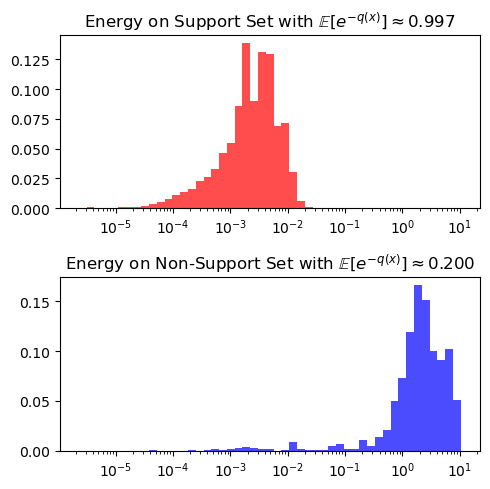

In [16]:
# cat X and Y
whole_data_points = torch.tensor(np.stack([X, Y], axis=-1).reshape(-1, 2)).cuda().float()
non_support_data = whole_data_points[(whole_data_points[:, 0] > 0.1)  | (whole_data_points[:, 0] < -0.1) | (whole_data_points[:, 1] > 0.1) | (whole_data_points[:, 1] < -0.1)]
support_data = torch.from_numpy(dataset).float().cuda()

non_support_energy = model_to_test.energy(non_support_data, 0+torch.zeros(non_support_data.shape[0]).long().cuda()).detach().cpu().numpy()
support_energy = model_to_test.energy(support_data, 0+torch.zeros(support_data.shape[0]).long().cuda()).detach().cpu().numpy()

# plot the histograms of the energy
plt.clf()
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, figsize=(5, 5))
i = 0

bins = np.logspace(np.log10(min(non_support_energy.min(), support_energy.min())), 
                   np.log10(max(non_support_energy.max(), support_energy.max())), 50)

# Plot histogram for support_energy
Z_support_value = np.exp(-support_energy).mean() * (2 * 0.2)
axs[i].hist(support_energy, bins=bins, weights=np.ones((len(support_energy),))/len(support_energy), color='red', alpha=0.7)#, density=True)
axs[i].set_title(r'Energy on Support Set with $\mathbb{{E}}[e^{{-q(x)}}] \approx {:.3f}$'.format(np.exp(-support_energy).mean()))
axs[i].set_xscale('log')
i += 1

# Plot histogram for non_support_energy
Z_non_support_value = np.exp(-non_support_energy).mean() * (4 * 4 - 2 * 0.2)
axs[i].hist(non_support_energy, bins=bins, weights=np.ones((len(non_support_energy),))/len(non_support_energy), color='blue', alpha=0.7)#, density=True)
axs[i].set_title(r'Energy on Non-Support Set with $\mathbb{{E}}[e^{{-q(x)}}] \approx {:.3f}$'.format(np.exp(-non_support_energy).mean()))
axs[i].set_xscale('log')
i += 1

plt.tight_layout()
plt.savefig('figures/proof_of_concept/histogram.png')

# Show the plot
plt.show()

# Merge the above three plots

In [20]:
list_of_pics = ['figures/proof_of_concept/target_distribution.png', 'figures/proof_of_concept/energy_landscape.png', 'figures/proof_of_concept/histogram.png']
from utils import merge_pic_in_a_row
merge_pic_in_a_row(list_of_pics, 'figures/proof_of_concept/merge.png')